In [ ]:
pip install -r requirements.txt
print("restart the kernel after installing the requirements")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# === Core Python & Utilities ===
import os
import joblib
from concurrent.futures import ProcessPoolExecutor

# === Numerical & Data Handling ===
import numpy as np
import pandas as pd
import dask.dataframe as dd
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import find_peaks

# === Plotting ===
import matplotlib.pyplot as plt

# === Machine Learning ===
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.layers import (
    Layer, Conv1D, MaxPooling1D, BatchNormalization, Dropout,
    Activation, Dense, Flatten, Reshape
)


In [ ]:
def custom_loss_improved(y_true, y_pred):
    # Weighted focal MSE
    alpha = 6.0
    gamma = 2.0
    weight = 1 + alpha * K.abs(y_true)
    error = y_true - y_pred
    focal_weight = K.pow(K.abs(error), gamma)
    mse_loss = K.mean(weight * focal_weight * K.square(error))

    pos_mask = K.cast(K.greater(K.abs(y_true), 0.6), 'float32')
    neg_mask = 1.0 - pos_mask
    pos_count = K.sum(pos_mask) + K.epsilon()
    neg_count = K.sum(neg_mask) + K.epsilon()
    pos_mean = K.sum(K.abs(y_pred) * pos_mask) / pos_count
    neg_mean = K.sum(K.abs(y_pred) * neg_mask) / neg_count
    margin = 0.6
    ranking_loss = K.relu(margin - (pos_mean - neg_mean))

    return mse_loss + 0.1 * ranking_loss

In [3]:
# Load the worn-unworn model
xgboost_worn_unworn_model = XGBClassifier()
xgboost_worn_unworn_model.load_model('models/worn_unworn_xgboost_model.json')
print("🚀 Worn-Unworn predict XGboost model loaded successfully!")

# load score prediction models (unet, lstm)

unet_model_path = "models/unet1d_with_attention.keras"

score_predict_unet_model = keras.models.load_model(
    unet_model_path,
    custom_objects={
        "custom_loss_improved": custom_loss_improved
    }
)

print("🚀 Score predict UNET model loaded successfully!")

lstm_model_path = "models/lstm_with_attention.keras"

score_predict_lstm_model = keras.models.load_model(
    lstm_model_path,
    custom_objects={
        "custom_loss_improved": custom_loss_improved
            }
)
print("🚀 Score predict LSTM model loaded successfully!")


🚀 Worn-Unworn predict XGboost model loaded successfully!
🚀 Score predict UNET model loaded successfully!
🚀 Score predict LSTM model loaded successfully!


c:\Users\rotem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 33 variables whereas the saved optimizer has 1 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
# Load test data

test_series = pd.read_parquet('data/train_series_for_demo.parquet')

# Define a custom bucket: 18:00 to 18:00 the following day
def assign_bucket(timestamp):
    if timestamp.hour >= 18:
        return timestamp.date()
    else:
        return (timestamp - pd.Timedelta(days=1)).date()

def process_series_df(series_id):
    # Step 1: Check if required columns exist
    required_cols = ['series_id', 'timestamp', 'anglez', 'enmo', 'step']
    missing_cols = [col for col in required_cols if col not in test_series.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        return []

    # Step 2: Filter the series
    series_df = test_series[test_series['series_id'] == series_id].copy()
    if series_df.empty:
        return []

    # Step 3: Handle missing anglez column
    if series_df['anglez'].isna().all():
        return []

    # Step 4: Fill missing values in relevant columns (forward fill)
    series_df[['timestamp', 'anglez', 'enmo', 'step']] = (
        series_df[['timestamp', 'anglez', 'enmo', 'step']].ffill()
    )

    # Step 5: Convert timestamp safely
    series_df['timestamp'] = pd.to_datetime(series_df['timestamp'], errors='coerce', utc=True)
    if series_df['timestamp'].isna().all():
        return []

    # Step 6: Extract time-based features
    series_df['date_hour_minute'] = series_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    series_df['hour'] = series_df['timestamp'].dt.hour

    # Step 7: Compute anglez value counts
    series_df['anglez_value_counts'] = series_df['anglez'].map(series_df['anglez'].value_counts())

    # Step 8: Group by minute
    series_minute_grouped = series_df.groupby('date_hour_minute').agg({
        'anglez': ['mean', 'std', 'median'],
        'enmo': ['mean', 'std', 'median'],
        'step': 'min',
        'hour': 'first',
        'anglez_value_counts': 'max',
    }).reset_index()

    if series_minute_grouped.empty:
        return []

    # Step 9: Rename columns
    series_minute_grouped.columns = [
        'date_hour_minute', 'anglez_mean', 'anglez_std', 'anglez_med',
        'enmo_mean', 'enmo_std', 'enmo_med', 'step_min',
        'hour', 'anglez_value_counts'
    ]

    # Step 10: Parse date_hour_minute and assign bucket
    series_minute_grouped['date_hour_minute'] = pd.to_datetime(
        series_minute_grouped['date_hour_minute'], errors='coerce'
    )

    series_minute_grouped['bucket'] = series_minute_grouped['date_hour_minute'].apply(assign_bucket)

    return series_minute_grouped
      
def process(series_id):
  print(f"start processing {series_id}")
  series_minute_grouped = process_series_df(series_id)
  if series_minute_grouped.empty:
        print(f"No valid data for series_id {series_id}")
        return []
  series_minute_grouped['bucket'] = series_minute_grouped['bucket'].astype(str)

  # Group data into buckets (dates)
  buckets = series_minute_grouped.groupby('bucket')

  # Store data for each bucket as arrays
  bucket_arrays = []

  for bucket, group in buckets:
      step = group['step_min'].to_numpy()
      hour = group['hour'].to_numpy()
      enmo_values = group['enmo_mean'].to_numpy()
      enmo_std_values = group['enmo_std'].to_numpy()
      anglez_values = group['anglez_mean'].to_numpy()
      anglez_values = np.clip(anglez_values, -90, 90)
      anglez_log_values = np.log1p(anglez_values + 91)  # Apply shift by 91 so the range is 1-181 and log1p transformation
      anglez_std_values = group['anglez_std'].to_numpy()
      anglez_value_counts = group['anglez_value_counts'].to_numpy()
      bucket_arrays.append({
          'series_id': series_id,
          'bucket': bucket,
          'step': step,
          'hour': hour,
          'enmo': enmo_values,
          'enmo_std' : enmo_std_values,
          'anglez_log': anglez_log_values,
          'anglez_std' : anglez_std_values,
          'anglez_value_counts' : anglez_value_counts,
      })
  print(f"finished processing {series_id}")
  return bucket_arrays

In [5]:
TARGET_LENGTH = 1440

def pad_to_length_edge(array, target_length=1440):
    pad_length = target_length - len(array)
    if pad_length > 0:
        return np.pad(array, (0, pad_length), mode='edge')
    return array

series_ids = test_series['series_id'].unique()
results = [process(series_id) for series_id in series_ids]

flat_data = []
for result in results:
    for bucket in result:
        flat_data.append({
            "series_id": bucket['series_id'],
            "bucket": bucket['bucket'],
            "step": bucket['step'],
            "hour": bucket['hour'],
            "enmo": list(bucket['enmo']),
            "enmo_std": list(bucket['enmo_std']),
            "anglez_log": list(bucket['anglez_log']),
            "anglez_std": list(bucket['anglez_std']),
            "anglez_value_counts": list(bucket['anglez_value_counts']),
        })

buckets = pd.DataFrame(flat_data)

# Apply padding to each feature column
for col in ['step', 'enmo', 'hour', 'enmo_std', 'anglez_log', 'anglez_std', 'anglez_value_counts']:
    buckets[col] = buckets[col].apply(lambda x: pad_to_length_edge(x, 1440))

start processing 038441c925bb
finished processing 038441c925bb
start processing 03d92c9f6f8a
finished processing 03d92c9f6f8a
start processing 0402a003dae9
finished processing 0402a003dae9


In [6]:
buckets

,series_id,bucket,step,hour,enmo,enmo_std,anglez_log,anglez_std,anglez_value_counts
0,038441c925bb,2018-08-14,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, ...","[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[0.021775, 0.020275, 0.017383333, 0.013625, 0....","[0.00042666777, 0.007940933, 0.016364975, 0.00...","[4.5506063, 4.788092, 3.8140717, 2.4857023, 2....","[0.14364772, 28.073221, 50.07179, 0.014131226,...","[4, 5, 3, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 8, 7, ..."
1,038441c925bb,2018-08-15,"[16200, 16212, 16224, 16236, 16248, 16260, 162...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.0045749997, 0.00495, 0.0040166667, 0.173, 0...","[0.00323029, 0.00096906716, 0.0025037548, 0.16...","[3.4912496, 3.5865278, 3.580433, 4.2837863, 4....","[1.6600451, 0.3296081, 0.8896668, 17.470861, 1...","[3, 2, 2, 6, 2, 4, 2, 1, 3, 1, 1, 3, 2, 2, 9, ..."
2,038441c925bb,2018-08-16,"[33480, 33492, 33504, 33516, 33528, 33540, 335...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.030016668, 0.025466666, 0.023599999, 0.0233...","[0.008606956, 0.012899354, 0.015728435, 0.0114...","[4.2116613, 4.2629676, 4.390096, 4.374196, 4.7...","[23.401093, 26.725136, 23.412292, 24.102478, 3...","[5, 2, 2, 2, 2, 1, 2, 10, 6, 2, 2, 5, 7, 2, 1,..."
3,038441c925bb,2018-08-17,"[50760, 50772, 50784, 50796, 50808, 50820, 508...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.0216, 0.09978333, 0.117466666, 0.31455, 0.1...","[0.04873216, 0.100609064, 0.15281032, 0.360129...","[4.2565255, 4.4347672, 4.402465, 4.511154, 4.4...","[9.32305, 12.239249, 13.909476, 18.26093, 12.7...","[4, 5, 2, 1, 5, 6, 1, 5, 2, 2, 2, 2, 2, 2, 2, ..."
4,038441c925bb,2018-08-18,"[68040, 68052, 68064, 68076, 68088, 68100, 681...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.04966667, 0.05539167, 0.10069167, 0.043525,...","[0.018968986, 0.031894926, 0.022147868, 0.0214...","[4.7390003, 4.693468, 4.6759872, 4.284138, 2.6...","[22.325626, 26.652126, 22.514347, 52.74414, 2....","[1, 3, 2, 1, 1, 3, 1, 2, 3, 2, 2, 3, 2, 5, 2, ..."
...,...,...,...,...,...,...,...,...,...
85,0402a003dae9,2019-01-05,"[311220, 311232, 311244, 311256, 311268, 31128...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.07351667, 0.09479167, 0.052183334, 0.092441...","[0.042422544, 0.06223728, 0.059743386, 0.05413...","[4.150642, 4.3053064, 4.0853662, 4.3071, 4.296...","[16.890211, 29.294594, 13.667937, 13.810316, 1...","[2, 4, 2, 1, 7, 1, 3, 6, 4, 7, 2, 1, 2, 1, 2, ..."
86,0402a003dae9,2019-01-06,"[328500, 328512, 328524, 328536, 328548, 32856...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.016216667, 0.0172, 0.023058333, 0.014733333...","[0.0070465766, 0.011086191, 0.017461099, 0.011...","[4.7513094, 4.634535, 4.753653, 4.6456947, 4.5...","[6.731055, 6.769245, 10.869964, 8.371932, 7.47...","[5, 3, 7, 2, 7, 3, 2, 3, 2, 2, 3, 6, 2, 2, 3, ..."
87,0402a003dae9,2019-01-07,"[345780, 345792, 345804, 345816, 345828, 34584...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.036841664, 0.038083334, 0.0015666666, 0.000...","[0.002112499, 0.033440147, 0.004440584, 0.0012...","[4.045244, 4.4024205, 4.473194, 4.436347, 4.52...","[2.935906, 21.563911, 12.026747, 2.4791555, 5....","[2, 1, 2, 2, 6, 2, 2, 2, 3, 3, 2, 2, 3, 6, 2, ..."
88,0402a003dae9,2019-01-08,"[363060, 363072, 363084, 363096, 363108, 36312...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.0033249997, 0.0077500003, 0.012366666, 0.02...","[0.0043140627, 0.0058947587, 0.011197266, 0.02...","[5.0359626, 5.0533533, 4.881988, 4.7270966, 4....","[1.7113817, 5.9117846, 31.620895, 17.28835, 14...","[2, 2, 4, 2, 3, 7, 2, 2, 2, 3, 2, 2, 6, 2, 5, ..."


In [7]:
buckets['anglez_log_ewma'] = buckets['anglez_log'].apply(lambda x: pd.Series(x).ewm(span=30).mean().to_numpy())
buckets['enmo_ewma'] = buckets['enmo'].apply(lambda x: pd.Series(x).ewm(span=30).mean().to_numpy())
for col_name in ['enmo', 'enmo_std', 'anglez_log', 'anglez_std', 'anglez_log_ewma', 'enmo_ewma']:
  buckets[col_name] = buckets[col_name].apply(lambda arr: (arr - np.mean(arr)) / np.std(arr) if np.std(arr) != 0 else arr)


# Efficient sliding window std
def sliding_window_std(array, window_size=10):
    if len(array) < window_size:
        return np.array([0] * len(array))  # Handle edge cases
    windows = sliding_window_view(array, window_shape=window_size)  # Create overlapping windows
    return np.std(windows, axis=1)

# Efficient sliding window mad
def sliding_window_mad(array, window_size=10):
    if len(array) < window_size:
        return np.array([0] * len(array))  # Handle edge cases
    windows = sliding_window_view(array, window_shape=window_size)  # Create overlapping windows
    return np.mean(np.abs(np.diff(windows, axis=1)), axis=1)
def pad_to_length_constant(array, target_length=1440):
    pad_length = target_length - len(array)
    if pad_length > 0:
        return np.pad(array, (0, pad_length), mode='constant')
    return array
buckets['anglez_log_std'] = buckets['anglez_log'].apply(lambda x: sliding_window_std(np.array(x), window_size=30))
buckets['anglez_log_mad'] = buckets['anglez_log'].apply(lambda x: sliding_window_mad(np.array(x), window_size=30))


# Pad the sliding window results
buckets['anglez_log_std'] = buckets['anglez_log_std'].apply(lambda x: pad_to_length_edge(x, 1440))
buckets['anglez_log_mad'] = buckets['anglez_log_mad'].apply(lambda x: pad_to_length_edge(x, 1440))
buckets['hour_sin'] = buckets['hour'].apply(lambda x: np.sin(2 * np.pi * x / 24))
buckets['hour_cos'] = buckets['hour'].apply(lambda x: np.cos(2 * np.pi * x / 24))

In [8]:
buckets

,series_id,bucket,step,hour,enmo,enmo_std,anglez_log,anglez_std,anglez_value_counts,anglez_log_ewma,enmo_ewma,anglez_log_std,anglez_log_mad,hour_sin,hour_cos
0,038441c925bb,2018-08-14,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, ...","[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[-0.16349883, -0.1931289, -0.25024912, -0.3244...","[-0.4392864, -0.27086866, -0.08205997, -0.4434...","[0.6985727, 1.0362152, -0.3485857, -2.2371774,...","[-0.70323086, 1.7682015, 3.7148108, -0.7146914...","[4, 5, 3, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 8, 7, ...","[0.8725303289338173, 1.089174254438979, 0.5494...","[-0.26692548136100913, -0.2915036204859992, -0...","[0.89791876, 0.73390454, 0.42375478, 0.2133160...","[0.18588975, 0.17484583, 0.13354398, 0.0697622...","[-0.9659258262890684, -0.9659258262890684, -0....","[0.2588190451025203, 0.2588190451025203, 0.258..."
1,038441c925bb,2018-08-15,"[16200, 16212, 16224, 16236, 16248, 16260, 162...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.5445473, -0.5384195, -0.55367094, 2.207655...","[-0.3984071, -0.43412158, -0.40988225, 2.16966...","[-1.1600173, -1.0104151, -1.0199851, 0.0843932...","[-0.7463166, -0.8548056, -0.8091363, 0.5429577...","[3, 2, 2, 6, 2, 4, 2, 1, 3, 1, 1, 3, 2, 2, 9, ...","[-1.9347463550547446, -1.8052268886571032, -1....","[-0.8166037670768754, -0.8118206280960815, -0....","[0.7434438, 0.72646856, 0.7096838, 0.7032251, ...","[0.4639852, 0.46537545, 0.4720887, 0.46688214,...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e..."
2,038441c925bb,2018-08-16,"[33480, 33492, 33504, 33516, 33528, 33540, 335...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.23109697, 0.09120488, 0.033813287, 0.026639...","[-0.20623524, -0.11359837, -0.052542243, -0.14...","[-0.008634078, 0.08142903, 0.30459088, 0.27667...","[1.3266863, 1.6417787, 1.327748, 1.3931719, 2....","[5, 2, 2, 2, 2, 1, 2, 10, 6, 2, 2, 5, 7, 2, 1,...","[-0.012038714106808387, 0.0613677629008625, 0....","[0.4748477605776372, 0.3245841466999011, 0.232...","[0.52915615, 0.5322287, 0.5383002, 0.5455826, ...","[0.52466506, 0.54221463, 0.5389059, 0.54099405...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e..."
3,038441c925bb,2018-08-17,"[50760, 50772, 50784, 50796, 50808, 50820, 508...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.2527756, 1.1799846, 1.5040432, 5.1157236, ...","[0.28345567, 1.0553511, 1.8320727, 4.9168553, ...","[0.15004267, 0.43735644, 0.38528717, 0.5604871...","[-0.24063708, -0.0013753887, 0.13565959, 0.492...","[4, 5, 2, 1, 5, 6, 1, 5, 2, 2, 2, 2, 2, 2, 2, ...","[0.2259748702292939, 0.43166077373928735, 0.47...","[-0.4886070050651297, 0.9160947103060656, 1.60...","[0.8977817, 0.8797527, 0.85544384, 0.84320396,...","[0.48403326, 0.4991964, 0.5089689, 0.51208097,...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e..."
4,038441c925bb,2018-08-18,"[68040, 68052, 68064, 68076, 68088, 68100, 681...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.6479936, 0.8932235, 2.833645, 0.38491568, -...","[0.572238, 1.5555285, 0.8140591, 0.75956106, -...","[1.5341367, 1.3622736, 1.2962915, -0.18275754,...","[4.216422, 5.2023964, 4.2594304, 11.148555, -0...","[1, 3, 2, 1, 1, 3, 1, 2, 3, 2, 2, 3, 2, 5, 2, ...","[2.9966843476795235, 2.823880759809831, 2.7206...","[0.7927296714407751, 0.9473498559096987, 1.841...","[2.047307, 2.0338085, 2.022168, 2.0138903, 2.0...","[0.8293567, 0.83848834, 0.8379021, 0.81733215,...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0402a003dae9,2019-01-05,"[311220, 311232, 311244, 311256, 311268, 31128...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.8407502, 1.3094898, 0.37072545, 1.2577137, ...","[0.46789107, 0.966778, 0.90398777, 0.7626776, ...","[-0.27645826, -0.082700685, -0.3

In [9]:
# Feature engineering: Prepare features and targets
features = []
for _, row in buckets.iterrows():
    # Stack all features into a single array for the row
    feature_matrix = np.column_stack([
        row['anglez_log_ewma'],
        row['anglez_log_std'],
        row['anglez_log_mad'],
        row['enmo_ewma'],
        row['enmo_std'],
        row['anglez_std'],
        row['anglez_value_counts'],
        row['hour_sin'],
        row['hour_cos']
    ])
    features.append(feature_matrix)
# Convert features and targets to numpy arrays
X_test = np.array(features)  # Shape: (n_samples, 1440, n_features)

# Flatten the input arrays into 1D vectors
if X_test.size != 0:
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)  # Shape: (num_samples, features)
    print(f"Shape of flattened X: {X_test_flattened.shape}")
    worn_predictions = xgboost_worn_unworn_model.predict(X_test_flattened)
    buckets['worn'] = worn_predictions
    filtered_buckets = buckets[buckets['worn'] == 1]
else:
    filtered_buckets = buckets

Shape of flattened X: (90, 12960)


In [10]:
filtered_buckets.shape

(45, 16)

In [11]:
# Extract features
features = []
for _, row in filtered_buckets.iterrows():
# Stack features: each is a 1440-length array for one day
    feature_matrix = np.column_stack([
    row['anglez_log_ewma'],
    row['anglez_log_std'],
    row['anglez_log_mad'],
    row['enmo_ewma'],
    row['enmo_std'],
    row['anglez_std'],
    row['anglez_value_counts'],
    row['hour_sin'],
    row['hour_cos']
    ])
    features.append(feature_matrix)

X = np.array(features)  # Ensure shape: (n_samples, 1440, n_features)

# Predict using the trained models
sleep_awake_predictions_1 = score_predict_unet_model.predict(X)
sleep_awake_predictions_2 = score_predict_lstm_model.predict(X)

# Assign predictions to the DataFrame  
filtered_buckets["predicted_target"] = [(0.6*sleep_awake_predictions_1[i].flatten()+0.4*sleep_awake_predictions_2[i].flatten()) for i in range(len(filtered_buckets))]

# Save results
filtered_buckets.to_parquet("buckets_for_post_processing.parquet", index=False)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 70s 37s/step


C:\Users\rotem\AppData\Local\Temp\ipykernel_33324\2818354561.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_buckets["predicted_target"] = [(0.6*sleep_awake_predictions_1[i].flatten()+0.4*sleep_awake_predictions_2[i].flatten()) for i in range(len(filtered_buckets))]


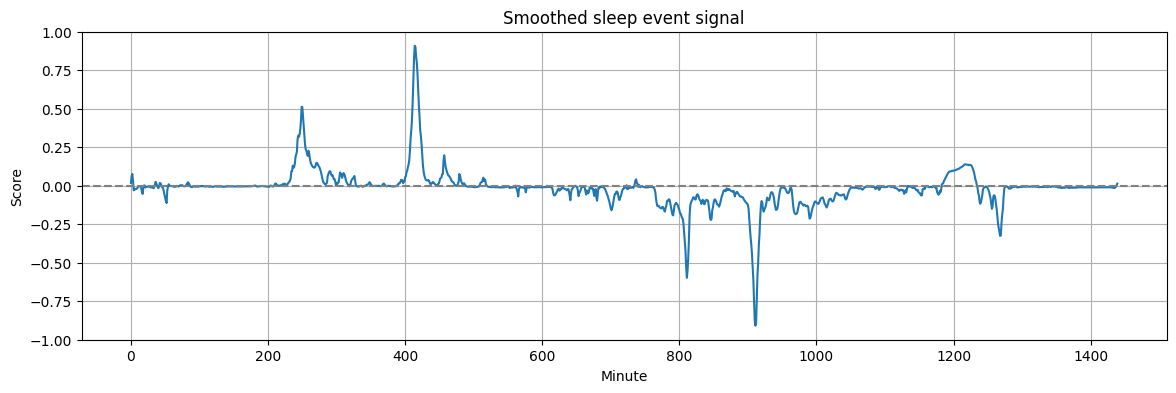

In [ ]:
# Visualization of predicted_target for first series_id and first day

import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_parquet('buckets_for_post_processing.parquet')

plt.figure(figsize=(14, 4))
plt.plot(df['predicted_target'].iloc[0])
plt.axhline(0, color="gray", linestyle="--")
plt.title("Smoothed sleep event signal")
plt.xlabel("Minute")
plt.ylabel("Score")
plt.grid(True)
plt.show()

In [12]:
# Load data using Dask
df = dd.read_parquet('buckets_for_post_processing.parquet')

threshold_onset, threshold_wakeup = 0.05, 0.05

# Step adjustment based on empirical insights
def adjust_step(step, event_type):
    step = int(step)  # ensure it's a standard Python integer
    if step % 12 in [0, 6]:
        step -= 1
    e15 = event_type[0] + str((step // 12) % 15)
    if e15 in ['o1', 'o8', 'o9', 'w0', 'w4', 'w8', 'w12']:
        step -= 12
    elif e15 in ['o4', 'o12', 'w1', 'w5', 'w9', 'w13']:
        step += 12
    return step

# Comprehensive event extraction accounting for sleep breaks
def process_partition(partition_df):
    min_sleep_duration, max_sleep_duration = 60 * 12, 1000 * 12
    max_sleep_break = 30 * 12  # 30 minutes in steps
    submission_rows = []

    for idx, row in partition_df.iterrows():
        predicted_scores = row['predicted_target']
        if predicted_scores is None:
          print(idx)
          continue  # Skip rows where predicted_scores are None

        predicted_scores = np.array(predicted_scores).flatten()

        steps = np.array(row['step'], dtype=np.int64) 

        onset_peaks, _ = find_peaks(predicted_scores, height=threshold_onset)
        wakeup_peaks, _ = find_peaks(-predicted_scores, height=threshold_wakeup)

        onset_steps_adjusted = [adjust_step(steps[idx], 'onset') for idx in onset_peaks]
        wakeup_steps_adjusted = [adjust_step(steps[idx], 'wakeup') for idx in wakeup_peaks]

        onset_scores = predicted_scores[onset_peaks]
        wakeup_scores = predicted_scores[wakeup_peaks]

        for onset_step, onset_score in zip(onset_steps_adjusted, onset_scores):
            for wakeup_step, wakeup_score in zip(wakeup_steps_adjusted, wakeup_scores):
                duration = wakeup_step - onset_step
                if duration < 0:
                    continue
                if min_sleep_duration <= duration <= max_sleep_duration or (0 < duration <= max_sleep_break):
                  if abs(onset_score) > threshold_onset:
                      submission_rows.append({
                          'series_id': str(row['series_id']),
                          'step': int(onset_step),
                          'event': 'onset',
                          'score': float(abs(onset_score))
                      })

                  if abs(wakeup_score) > threshold_wakeup:
                      submission_rows.append({
                          'series_id': str(row['series_id']),
                          'step': int(wakeup_step),
                          'event': 'wakeup',
                          'score': float(abs(wakeup_score))
                      })
    if submission_rows:
        return pd.DataFrame(submission_rows).drop_duplicates()
    else:
        return pd.DataFrame(columns=['series_id', 'step', 'event', 'score'])

# Apply processing to each partition
results = df.map_partitions(process_partition, meta={
    'series_id': str,
    'step': int,
    'event': str,
    'score': float
})

# Compute results, assign row_id, and save
submission_df = results.reset_index(drop=True).compute()
submission_df['row_id'] = submission_df.index
submission_df = submission_df[['row_id', 'series_id', 'step', 'event', 'score']]
submission_df.to_csv('submission.csv', index=False)